In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from geopy.geocoders import Nominatim
import plotly.graph_objects as go
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
from shapely.geometry import Point
import src.CleaningFunctions as cf


In [5]:
df_sharks=pd.read_pickle("df_sharks_")

### Lets start with some easy hyphotesis about some columns and then we will see the maps

   ### 1. Year: Are the sharks attacks continuous rising on time (years)? 

In [6]:
#we filled the Nans with 0 so that  then will be easier to be filtered it
df_sharks['Year'].fillna(value=0, inplace=True)


In [7]:
#we change the data type as it is a float and we need an Integer
df_sharks = df_sharks.astype({"Year": int})


<AxesSubplot:xlabel='Year', ylabel='Count'>

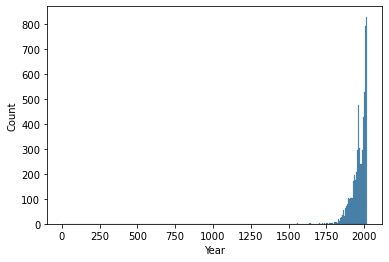

In [8]:
# We create an histogram with the attacks from the year 0 (not included)
filtered_year_0 = df_sharks[df_sharks['Year']>0]
sns.histplot(x=filtered_year_0['Year'])


<AxesSubplot:xlabel='Year', ylabel='Count'>

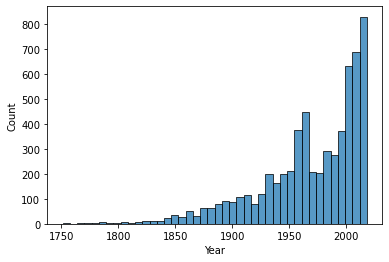

In [9]:
#We can see the important number of atacks begins around the year 1750
attacks_from_1750 = (df_sharks [df_sharks['Year']>1750])
sns.histplot(x=attacks_from_1750['Year'])

#### Are the sharks attacks continuous rising on time (years)? 

Is easy to think that this hyphotesis is true, but we can see that clearly is not always true.
There are some year where the sharks attacks descend on some year.
We could think that is because a war, or some kind of event which makes people not swimm in dangerous areas

## 2.- Sex: Are shark attacks more deahtly on Men or Women?




In this hyphotesis we need to play with 2 columns (Sex, Fatal (Y/N))

First we will check the different type of values we have on Fatal column

In [10]:
#lets see the value_counts of the Fatal column
df_sharks['Fatal (Y/N)'].value_counts()

N          4293
Y          1388
UNKNOWN      71
 N            7
M             1
2017          1
N             1
y             1
Name: Fatal (Y/N), dtype: int64

I have created a function  **get_correct_character(x)** , located on **./src/** for keeping only 3 values ( N,Y, Unknown). 

We will use this function (get_correct_character) to return the correct Character for Fatal (Y/N) column.

If the Character is not Y or N we will return "Unknown"


In [11]:
# We will apply the function get_correct_character over the Fatal column and we will 
# have just 3 values (Y, N, Unknown)
df_sharks["Fatal (Y/N)"] = df_sharks["Fatal (Y/N)"].apply(cf.get_correct_character)
df_sharks["Fatal (Y/N)"].unique()

array(['N', 'Y', 'Unknown'], dtype=object)

Now we will check the different types of values we have on Se column

In [12]:
#We check how many unique values we have for Sex 
df_sharks["Sex "].unique()

array(['F', 'M', nan, 'M ', 'lli', 'N', '.'], dtype=object)

I have created a function **get_correct_sex(x)** , located on **./src/** for keeping only 3 values ( M,F, Unknown).

We will use this function (get_correct_sex) to return the correct Character for Sex column.

If the Character is not M or F we will return "Unknown"


In [13]:
# We will apply the function get_correct_sex over the Sex column and we will 
# have just 3 values (F, M, Unknown)
df_sharks["Sex "] = df_sharks["Sex "].apply(cf.get_correct_sex)

<AxesSubplot:xlabel='Sex ', ylabel='count'>

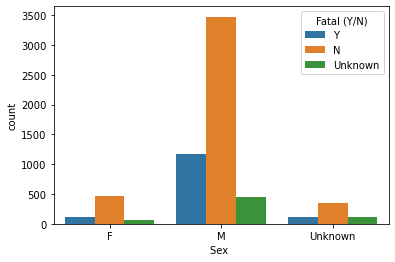

In [52]:
# We plot an histogram where we can see the number of atacks for Gender and if
# this attacks ended up on death
hue_order = ['Y', 'N', 'Unknown']
sns.countplot(x=df_sharks["Sex "], hue = df_sharks["Fatal (Y/N)"], hue_order=hue_order )

In [79]:
df_sex_death = df_sharks.groupby(["Sex ","Fatal (Y/N)"])["Case Number"].count()
df_sex_death

Sex      Fatal (Y/N)
F        N               467
         Unknown          63
         Y               107
M        N              3475
         Unknown         448
         Y              1172
Unknown  N               351
         Unknown         109
         Y               109
Name: Case Number, dtype: int64

In [80]:
male_death_proportion = ((df_sex_death[5])*100/df_sex_death[3])
female_death_proportion = ((df_sex_death[2])*100/df_sex_death[0])

print("male_death_proportion :",male_death_proportion)
print("female_death_proportion :",female_death_proportion)

male_death_proportion : 33.726618705035975
female_death_proportion : 22.91220556745182


 #### Are shark attacks more deahtly on Men or Women?
 
 We can conclude that women are more difficult tu catch than men

## COUNTRIES
### What are the countries with more attacks?


First we check the nulls on country columns and we fill them with the string "Unknown"

In [16]:
#Lets check how many nulls we have
len(df_sharks[df_sharks["Country"].isnull()])

50

In [17]:
#Lets fill those Na¡Ns with "Unknown"
df_sharks["Country"] = df_sharks["Country"].fillna("Unknown")
len(df_sharks[df_sharks["Country"].isnull()])

0

There are lots of Countries with very few attacks, so we are going to filter them showing countries with a minimum of attacks so that we can display them on a chart

In [19]:
#Lets filter the countries with more than 40 atacks
number_of_attacks = 40
countries_attack = df_sharks["Country"].value_counts() > number_of_attacks
countries_attack = countries_attack.to_frame()
countries_attack.reset_index()
countries_attack = list(countries_attack[(countries_attack["Country"]==True)].index)
df_country_filtered = df_sharks[(df_sharks["Country"].isin(countries_attack))]


<AxesSubplot:xlabel='Country', ylabel='Count'>

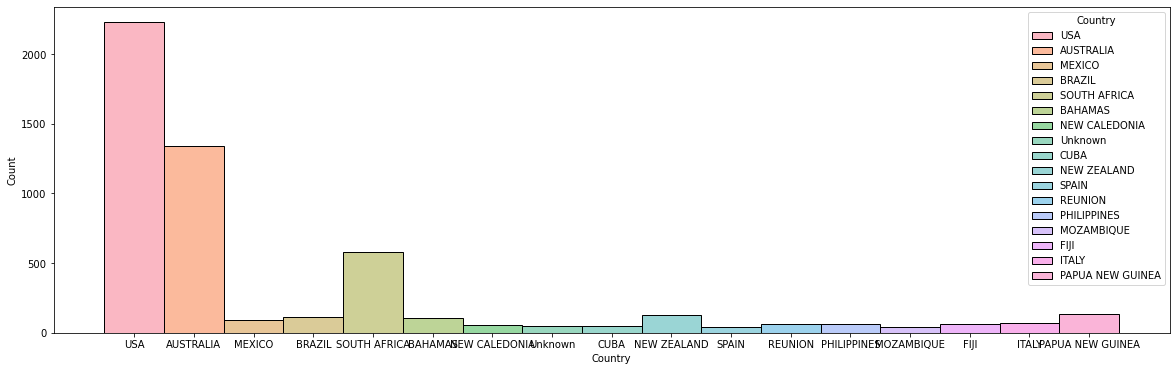

In [85]:
#Atacks per country where the number of atacks are over our variable number_of_attacks
plt.figure(figsize=(20, 6))
sns.histplot(x=df_country_filtered["Country"], hue=df_country_filtered["Country"])

### What are the countries with more attacks?
It is easy to see the most dangerous countries to go to swimm are USA, Australia and South Africa

## MAP SECTION

### Hypothesis
#### 1.- Which coasts are the ones with more number of attacks?
#### 2.- How are the sharks species distributed around the world?
#### 3.- How will be the distributions or death attacks around the world?


### Map Preprocesing
Before starting to demostrate our hypothesis, we need to create a Data Frame with the structure required for displaying them in a Map

The funtion **set_attacks_location()** on the cell bellow is the main function used for the creation of a Data Frame for the maps.
What this function do?
* Create the structure of data (list of dictionaries) to store the columns we need.
* Use GeoPandas library to get the latitude, longitude from a location and adding it to 
our structure. If we have any problem (exception) on the process we don't add the info but
we continue the iteration.
* Get info from the columns: Location, Species, Fatal and Year but keeping only the ones
where we get a correct latitude longitude 
* Create a Data Frame from our structure and save it in a pickle file:
    * The process of getting latitude, longitude from a location is very slow so we need to save that info in a file so that we can recover it at the momment we would like to.

In [21]:
def set_attacks_location():
    attacks_loc = {"Location":"", "latitude":0, "longitude":0, "Species ":"", "Fatal (Y/N)":"", "Year":0} 
    list_attacks_loc = []
    location_places   = df_sharks["Location"]
    location_species  = df_sharks["Species "]
    location_fatal  =   df_sharks["Fatal (Y/N)"]
    location_Year =     df_sharks["Year"]
    for location_place, specie, fatal, year in zip(location_places,location_species, location_fatal, location_Year):
        if location_place is not None:
            geolocator = Nominatim(user_agent="Shark attacks")

            try:
                location = geolocator.geocode(location_place)
                attacks_loc = {"Location":"", "latitude":0, "longitude":0, "Species ":"", "Fatal (Y/N)":"", "Year":0}  
                attacks_loc["Location"] = location_place
                attacks_loc["latitude"] = location.latitude
                attacks_loc["longitude"] = location.longitude
                attacks_loc["Species "] = specie
                attacks_loc["Fatal (Y/N)"] = fatal
                attacks_loc["Year"] = year
                list_attacks_loc.append(attacks_loc)

            except Exception: 
                print("Location not found")

    # save
    df_attacks_loc = pd.DataFrame(list_attacks_loc)
    df_attacks_loc.to_pickle("df_attacks_loc_")

As we commented before, this is a long process, so we havee the code line below commented as we have executed it just once. 

In [22]:
#set_attacks_location()

On the next cell we are loading the pickle dataframe that we previously saved on set_attacks_location() function

In [23]:
df_attacks_loc=pd.read_pickle("df_attacks_loc_")
df_attacks_loc

,Location,latitude,longitude,Species,Fatal (Y/N),Year
0,"Oceanside, San Diego County",33.195870,-117.379483,white shark,N,2018
1,"St. Simon Island, Glynn County",31.170787,-81.407320,Other,N,2018
2,Arrawarra Headland,-30.060426,153.201685,Other,N,2018
3,La Ticla,18.454657,-103.553812,tiger shark,N,2018
4,"Flat Rock, Ballina",-28.842955,153.607990,Other,N,2018
...,...,...,...,...,...,...
4661,NaN,46.314475,11.048029,Other,Y,0
4662,NaN,46.314475,11.048029,Other,Y,0
4663,Roebuck Bay,-17.994960,122.321910,Other,Y,0
4664,NaN,46.314475,11.048029,Other,Y,0


After a quick view of the data we can see there are still Nans values for locations, and we need to get rid of them.
It is something we should've done on the cleaning stage but we just saw the problem so lets fix it

In [24]:
#Checking how many Nans we have
df_attacks_loc.isnull().sum()

Location       540
latitude         0
longitude        0
Species          0
Fatal (Y/N)      0
Year             0
dtype: int64

In [25]:
# Deleting all Nans the checking if we did it correctly
df_attacks_loc.dropna(axis=0, how='any', inplace=True)
df_attacks_loc.isnull().sum()

Location       0
latitude       0
longitude      0
Species        0
Fatal (Y/N)    0
Year           0
dtype: int64

### 1.- Which coasts are the ones with more number of attacks ? 

We use **geopandas** library to have a global idea about the location of the attacks around the world.
 
There are lots of attacks very close to each other so we need to use the alpha parameter to show more intensity of color where there are more atacks
 


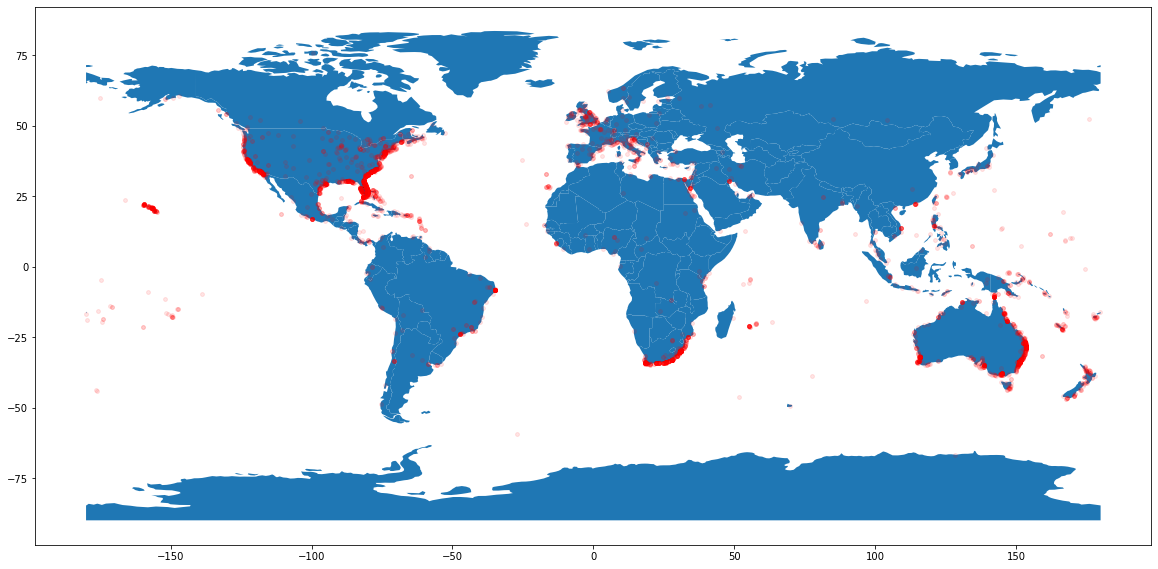

In [26]:
# This library needs to use their own types of objects (Points, geometry, GeoDataFrame)
# so we create them with the data we have in our dataframe

list_attacks_loc = df_attacks_loc.values.tolist()
geometry = []
for loc in list_attacks_loc:
    geometry.append(Point(loc[2],loc[1]))
gdf = GeoDataFrame(df_attacks_loc, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), 
         marker='o', color='red', markersize=15, alpha=0.1);

Same thing but using the interactive  **plotly**  library and the scatter method for maps **scatter_geo** where we can se the info of the atacks just moving the mouse over them.

In [51]:
fig = px.scatter_geo(df_attacks_loc,
                    lat="latitude",
                    lon="longitude",
                    hover_name="Location",
                    opacity = 0.1, 
                    width=700, height=500 )
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

Just with a quick view on the maps we can see that the intensity of the attacks are more clear on :
* North America West and East Coast
* South Africa Coast
* Austrila West Coast and East Coast with more intensity

Obviously there are more places with lots of attacks but not with that intensity

### 2.- How are the sharks species distributed around the world?

First of all we fill all Nans creating a new type of Specie: "Others"

In [28]:
# We will  use the column species this time
# Lets fill the Nans with the text  "Others"
df_attacks_loc["Species "] = df_attacks_loc["Species "].fillna("Others")

 We want to show just 5 different kind of sharks:
* White
* Tiger
* Lemon
* Bull
* Reef

So we will filter (using our new ReGex function  **kind_of_shark** located on *./src/CleaningFunctions.py* ) the Species columns looking for these 5 species on the text of the column Species


In [29]:
#Applying the function to the column
df_attacks_loc["Species "] = df_attacks_loc["Species "].apply(cf.kind_of_shark)

At this point we will only have the 5 species on the Species column (plus "Others").
Lets check it out.

In [30]:
df_attacks_loc["Species "].unique()

array(['white shark', 'Other', 'tiger shark', 'bull shark', 'reef shark',
       'lemon shark'], dtype=object)

In [31]:
df_attacks_loc

,Location,latitude,longitude,Species,Fatal (Y/N),Year,geometry
0,"Oceanside, San Diego County",33.195870,-117.379483,white shark,N,2018,POINT (-117.37948 33.19587)
1,"St. Simon Island, Glynn County",31.170787,-81.407320,Other,N,2018,POINT (-81.40732 31.17079)
2,Arrawarra Headland,-30.060426,153.201685,Other,N,2018,POINT (153.20169 -30.06043)
3,La Ticla,18.454657,-103.553812,tiger shark,N,2018,POINT (-103.55381 18.45466)
4,"Flat Rock, Ballina",-28.842955,153.607990,Other,N,2018,POINT (153.60799 -28.84296)
...,...,...,...,...,...,...,...
4656,Durban,-29.861825,31.009909,Other,Y,0,POINT (31.00991 -29.86182)
4657,Durban,-29.861825,31.009909,Other,Y,0,POINT (31.00991 -29.86182)
4659,Puna,-9.719806,124.456417,Other,N,0,POINT (124.45642 -9.71981)
4663,Roebuck Bay,-17.994960,122.321910,Other,Y,0,POINT (122.32191 -17.99496)


In [32]:
# Lets take a look to our dataframe
df_attacks_loc

,Location,latitude,longitude,Species,Fatal (Y/N),Year,geometry
0,"Oceanside, San Diego County",33.195870,-117.379483,white shark,N,2018,POINT (-117.37948 33.19587)
1,"St. Simon Island, Glynn County",31.170787,-81.407320,Other,N,2018,POINT (-81.40732 31.17079)
2,Arrawarra Headland,-30.060426,153.201685,Other,N,2018,POINT (153.20169 -30.06043)
3,La Ticla,18.454657,-103.553812,tiger shark,N,2018,POINT (-103.55381 18.45466)
4,"Flat Rock, Ballina",-28.842955,153.607990,Other,N,2018,POINT (153.60799 -28.84296)
...,...,...,...,...,...,...,...
4656,Durban,-29.861825,31.009909,Other,Y,0,POINT (31.00991 -29.86182)
4657,Durban,-29.861825,31.009909,Other,Y,0,POINT (31.00991 -29.86182)
4659,Puna,-9.719806,124.456417,Other,N,0,POINT (124.45642 -9.71981)
4663,Roebuck Bay,-17.994960,122.321910,Other,Y,0,POINT (122.32191 -17.99496)


### Map displaying 5 top shark species
Because we only are interested on our 5 top Species, we don't want to display them to have a more clear map, so we will drop the Species = "Other"

In [33]:
df_attacks_loc_species = df_attacks_loc[(df_attacks_loc["Species "] != "Other")]

In [34]:
fig = px.scatter_geo(df_attacks_loc_species,
                    lat="latitude",
                    lon="longitude",
                    hover_name="Location",
                    color =df_attacks_loc_species["Species "],
                    opacity = 0.3, 
                    width=700, height=500 )
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

Doing doble click on the leyend we can isolate any of the species on the map and we can see clearly that every kind of shark has their own areas (but sometimes really far away ones from another)

### Map with rivers
We can see plenty of attacks in the middle of nowhere, out of seas or oceans, so the next map will be one adding rivers and lakes, to check if there are sharks attacks on them

In [35]:
fig = px.scatter_geo(df_attacks_loc_species,
                    lat="latitude",
                    lon="longitude",
                    hover_name="Location",
                    color =df_attacks_loc_species["Species "],
                    opacity = 0.4, 
                    width=750, height=600 )

fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(
    resolution=50,
    showlakes=True, lakecolor="lightBlue",
    showrivers=True, rivercolor="lightBlue"
)
fig.show()

Doing zoom we can see that there are some longitude, latitud of attacks are exactly on rivers or lakes, but they are not most of them.

So, most of the are on land which makes no sense, but might be for different causes:
* Location Data is wrong in those cases
* GeoPandas library returns an incorrect longitude, latitude from a Location
* There are rivers or lakes which doesn't appear on the map.

### 3.- How will be the distributions or death attacks around the world?

In [36]:
df_attacks_loc["Fatal (Y/N)"] = df_attacks_loc["Fatal (Y/N)"].fillna("Unknown")

In [37]:
df_attacks_loc_fatal = df_attacks_loc[(df_attacks_loc["Fatal (Y/N)"] != "Unknown")]

## Map with deadly attacks info

In [38]:
fig = px.scatter_geo(df_attacks_loc_fatal,
                    lat="latitude",
                    lon="longitude",
                    hover_name="Location",
                    color =df_attacks_loc_fatal["Fatal (Y/N)"],
                    opacity = 0.3, 
                    width=700, height=500 )
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

There is not a big difference between locations where there are deahtly attacks and where there are not.
In this maps all kind of sharks has been added (included Others).


On the next cells we are going to investigate how deadly are our 5 top Species and their location around the world.

In [39]:
#We filter them
df_attacks_loc_fatal_5_species = df_attacks_loc_fatal[(df_attacks_loc_fatal["Species "]!= "Other")]

<AxesSubplot:xlabel='Fatal (Y/N)', ylabel='count'>

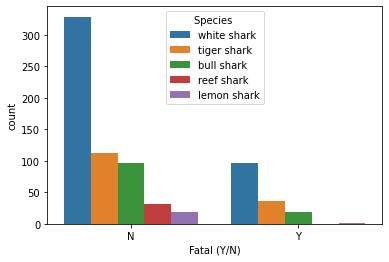

In [40]:
#We create a count plot
sns.countplot(x =df_attacks_loc_fatal_5_species["Fatal (Y/N)"], hue=df_attacks_loc_fatal_5_species["Species "] )

We check that there are 3 dangerous species (White Shark, Tiger Shark and Bull Shark).

## Map displaying death attacks info / Species 

Lets see the distribution of those species around the world on the next map.

Clicking on the leyend (Y = deadly, N = No deadly), we can filter and then can can move our mouse over the map to see which kind of shark did the attack.

In [41]:
fig = px.scatter_geo(df_attacks_loc_fatal_5_species,
                    lat="latitude",
                    lon="longitude",
                    hover_name="Species ",
                    color =df_attacks_loc_fatal_5_species["Fatal (Y/N)"],
                    opacity = 0.3, 
                    width=700, height=500 )
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [42]:
'''
TODO  Use Dash to use a slice for years (atacks per year)

import plotly.express as px
import geopandas as gpd


#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_geo(df_attacks_loc,
                    lat=df_attacks_loc["latitude"],
                    lon=df_attacks_loc["longitude"],
                    hover_name="Location",color =df_attacks_loc["Year"]>2000 )
fig.show()
''''

SyntaxError: EOL while scanning string literal (<ipython-input-42-523aef2697ea>, line 14)